Fitting population params so waterfall plot matches the real clinical trial one. Using Model ../final/pca_models/MLPRegressor_600_100_40_11_-7_6.pickle

In [1]:
import numpy as np

POPULATION_SIZE = 50_000
DISTRIBUTION_PARAMETERS = np.array(
    [
        [0.05, 0.5],
        [-2.436, 0.62335],
        [-2.58098, 0.69689],
        [0.2, 0.4],
        [0.005, 0.01],
        [0.01155, 0.0231],
        [0.15, 0.30],
        [150, 300],
        [0.75, 1.5],
        [1e-5, 0.01],
    ]
)
LOGNORMAL_PARAMETERS = (1, 2)

np.random.seed(seed=42)

In [2]:
# Loading model (including scaler, pca, dropping column 0 and transforming orders of magnitue to absolute values)

import time
from sklearn.preprocessing import MinMaxScaler
import pickle
from pathlib import Path


class CustomScaler:
    def __init__(self):
        super().__init__()
        self.scaler = MinMaxScaler()
        self.plot_loval = [0.0] * len(LOGNORMAL_PARAMETERS)
        self.plot_hival = [1.0] * len(LOGNORMAL_PARAMETERS)

    def transform(self, x: np.ndarray, copy=None) -> np.ndarray:
        res = self.scaler.transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = (x[:, parameter_index] - self.plot_loval[i]) / (self.plot_hival[i] - self.plot_loval[i])

        return res

    def fit(self, x, copy=None):
        self.scaler.fit(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            column_values = x[:, parameter_index]

            quantile_1, quantile_3 = np.quantile(column_values, [0.25, 0.75], axis=0)
            iqr = quantile_3 - quantile_1

            loval = quantile_1 - 1.5 * iqr
            hival = quantile_3 + 1.5 * iqr

            wiskhi = np.compress(column_values <= hival, column_values)
            wisklo = np.compress(column_values >= loval, column_values)
            actual_hival = np.max(wiskhi)
            actual_loval = np.min(wisklo)

            self.plot_loval[i] = actual_loval
            self.plot_hival[i] = actual_hival

        return self

    def inverse_transform(self, x, copy=None):
        res = self.scaler.inverse_transform(x)
        for i, parameter_index in enumerate(LOGNORMAL_PARAMETERS):
            res[:, parameter_index] = x[:, parameter_index] * (self.plot_hival[i] - self.plot_loval[i]) + self.plot_loval[i]
        return res
    
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline
from sklearn.neural_network import MLPRegressor
from threadpoolctl import threadpool_limits
from cpuinfo import get_cpu_info
from sklearn.decomposition import PCA


with Path(f"../final/scaler.pickle").open("rb") as scaler_file:
    scaler = pickle.load(scaler_file)

with Path(f"../final/pca/11_-7.pickle").open("rb") as opened_file:
    pca = pickle.load(opened_file)

with Path("../final/pca_models/MLPRegressor_600_100_40_11_-7_6.pickle").open("rb") as opened_file:
    regressor = pickle.load(opened_file)
    
def drop_treatment(input_data: np.ndarray) -> np.ndarray:
    """Drops treatment data from the dataset"""
    if input_data.shape[1] == 11:
        return input_data[:, 1:]

    return input_data

def predict(*args):
    return regressor.predict(*args)

def output_untransform(transformed_outputs: np.array) -> np.array:
    lower_limits = transformed_outputs <= -7
    z = 10 ** transformed_outputs
    z[lower_limits] = 0
    return z

model = make_pipeline(
    FunctionTransformer(drop_treatment),
    scaler,
    FunctionTransformer(predict),
    FunctionTransformer(pca.inverse_transform),
    FunctionTransformer(output_untransform)
)

In [3]:
# Generating parameters for each virtual patient in virtual population
# Note: To get virtual population with different distribution the alredy generated parameters are adjusted to the new distribution.


def generate_patient_indicators(size: int) -> np.ndarray:
    """
    Generates patient indicators.

    :param size: number of patients
    :return:
    """
    patient_indicators_arr = np.zeros((size, 11))
    patient_indicators_arr[:, 0] = np.ones(
        size
    )  # first indicator tells if treatment was applied

    for i, distribution_parameters in enumerate(DISTRIBUTION_PARAMETERS):
        if i in LOGNORMAL_PARAMETERS:
            patient_indicators_arr[:, i + 1] = np.random.lognormal(
                mean=distribution_parameters[0],
                sigma=distribution_parameters[1],
                size=size,
            )
        else:
            patient_indicators_arr[:, i + 1] = np.random.uniform(
                low=distribution_parameters[0],
                high=distribution_parameters[1],
                size=size,
            )

    return patient_indicators_arr

start_time = time.time()
patient_indicators = generate_patient_indicators(POPULATION_SIZE)
patient_indicators_generation_time_s = time.time() - start_time

print(
    f"Generated {POPULATION_SIZE} sets of patients indicators in {patient_indicators_generation_time_s} seconds"
)

Generated 50000 sets of patients indicators in 0.012151002883911133 seconds


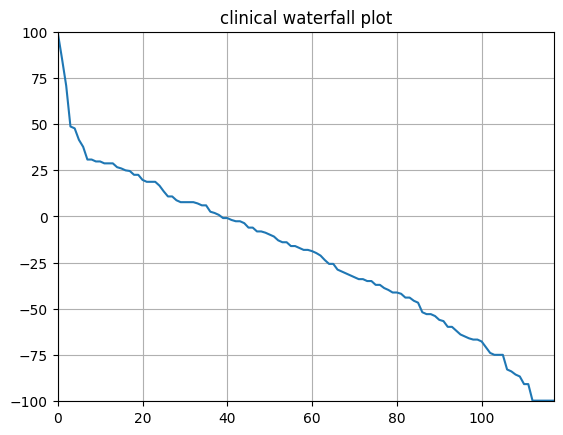

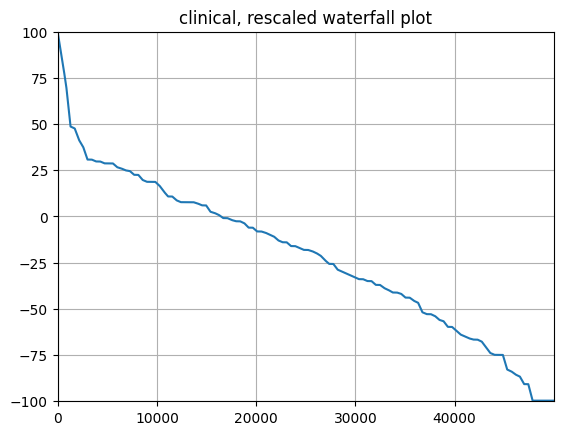

In [4]:
CLINICAL_WATERFALL_PLOT = '../final/Chatterjee_etal_2016_10mgperkg_Waterfall.csv'
population_data = np.loadtxt(CLINICAL_WATERFALL_PLOT, delimiter=",", skiprows=1, usecols=(1,))

import matplotlib.pyplot as plt

plt.title("clinical waterfall plot")
plt.grid()
plt.plot(population_data)
plt.xlim([0, 117])
plt.ylim([-100, 100])
plt.show()


from scipy import interpolate
waterfall_plot_interpolation = interpolate.interp1d(
    np.arange(0, len(population_data)) / (len(population_data) - 1), population_data
)
plt.title("interpolated clinical waterfall plot")
plt.grid()
plt.plot(waterfall_plot_interpolation(np.arange(POPULATION_SIZE) / (POPULATION_SIZE - 1)))
plt.xlim([0, POPULATION_SIZE - 1])
plt.ylim([-100, 100])
plt.show()



In [5]:
class TooManyDroppedCasesError(Exception):
    """Exception raised when too many cases were dropped by the model."""


class InvalidParametersError(Exception):
    """Exception raised when parameters passed to objective function are invalid"""


def validate_params(relative_params):
    for column in range(len(DISTRIBUTION_PARAMETERS)):
        i = column
        if column not in LOGNORMAL_PARAMETERS:
            absolute_params = DISTRIBUTION_PARAMETERS[column]
            low = absolute_params[0] + relative_params[i * 2] * (absolute_params[1] - absolute_params[0])
            high = absolute_params[0] + relative_params[i * 2 + 1] * (absolute_params[1] - absolute_params[0])

            if low * 1.01 < absolute_params[0] or high > absolute_params[1] * 1.01:
                raise InvalidParametersError(f"out of range on column {column} ({relative_params[2 * i]}, {relative_params[2 * i + 1]})")

            if relative_params[2 * i] >= relative_params[2 * i + 1]:
                raise InvalidParametersError(f"negative range at column {column} ({relative_params[2 * i]}, {relative_params[2 * i + 1]})")

def initial_relative_params(ratio):
    params = []
    for column in range(len(DISTRIBUTION_PARAMETERS)):
        if column in LOGNORMAL_PARAMETERS:
            params.append(0.0)
            params.append(ratio)
        else:
            params.append(1.0 - ratio)
            params.append(ratio)

    return np.array(params)
                
def adjust_patient_indicators(indicators, relative_params):
    global patient_indicators
    
    for i in range(len(DISTRIBUTION_PARAMETERS)):
        if i in LOGNORMAL_PARAMETERS:
            indicators[:, i + 1] = np.exp(
                (np.log(patient_indicators[:, i + 1]) - DISTRIBUTION_PARAMETERS[i][0])
                * (relative_params[2 * i + 1] / DISTRIBUTION_PARAMETERS[i][1])
                + DISTRIBUTION_PARAMETERS[i][0]
                + relative_params[2 * i]
            )
        else:
            indicators[:, i + 1] = (
                DISTRIBUTION_PARAMETERS[i][0]
                + relative_params[i * 2] * (DISTRIBUTION_PARAMETERS[i][1] - DISTRIBUTION_PARAMETERS[i][0])
                + (relative_params[2 * i + 1] - relative_params[2 * i]) * (patient_indicators[:, i + 1] - DISTRIBUTION_PARAMETERS[i][0])
            )
    return indicators

In [15]:
def waterfall_plot(indicators):
    time_profiles = model.transform(indicators)
    
    max_tumor_sizes = time_profiles.max(axis=1)
    final_tumor_sizes = time_profiles[:, -1]
    final_tumor_sizes[final_tumor_sizes < 0] = 0

    initial_tumor_sizes = indicators[:, 10]
    max_percent_change = 100.0 * (max_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes
    percent_change = 100.0 * (final_tumor_sizes - initial_tumor_sizes) / initial_tumor_sizes

    dropped_count = int(np.sum(max_percent_change > 100.0))
    if dropped_count / POPULATION_SIZE > 0.8:
        raise TooManyDroppedCasesError(f"Dropped {dropped_count} out of {POPULATION_SIZE} ({dropped_count * 100 / POPULATION_SIZE:.2f}%) time profiles")
    percent_change = percent_change[max_percent_change <= 100.0]
    percent_change[::-1].sort()
    
    return percent_change

In [12]:
minimize_history = []
indicators = np.copy(patient_indicators)

def minimize_objective(relative_params):
    global minimize_history, indicators
    
    try:
        validate_params(relative_params)
        adjust_patient_indicators(indicators, relative_params)
        
        virtual_waterfall_plot = waterfall_plot(indicators)
        waterfall_plot = waterfall_plot_interpolation(np.arange(virtual_waterfall_plot.shape[0]) / (virtual_waterfall_plot.shape[0] - 1))

        minimize_history.append((relative_params, np.linalg.norm(waterfall_plot - virtual_waterfall_plot)))
    except (InvalidParametersError, TooManyDroppedCasesError) as err:
        print(str(err))
        minimize_history.append((relative_params, float("inf")))
    
    return minimize_history[-1][1]
    
    

In [13]:
import scipy.optimize

iteration_options = {
    "method": "Nelder-Mead",
    "options": {
        "maxiter": 400
    }
}

with threadpool_limits(limits=get_cpu_info()["count"], user_api='blas'):
    result = scipy.optimize.minimize(
        minimize_objective,
        initial_relative_params(0.95),
        **iteration_options,
    )

out of range on column 0 (0.05168715913239774, 1.0137226600067268)
out of range on column 8 (0.0490031469433231, 1.0221676722270958)
out of range on column 9 (0.051643063416828394, 1.0373770470977335)
out of range on column 9 (0.05169438077654872, 1.0168084262053598)
out of range on column 9 (0.05329621980219236, 1.0134331402429169)
out of range on column 9 (0.05263070113539653, 1.011304519254229)
out of range on column 9 (0.05246044377820208, 1.0101292855285458)
out of range on column 9 (0.05447647338022115, 1.0127898218055003)
out of range on column 0 (0.05861169520858317, 1.016526600375049)
out of range on column 0 (0.059718218898451955, 1.0336836275552013)
out of range on column 0 (0.05983328481667646, 1.0260369905627473)
out of range on column 0 (0.052969728151374684, 1.0381242919340519)
out of range on column 0 (0.06053781933173334, 1.0336363308583665)
out of range on column 0 (0.06260077339815592, 1.0308950512832888)
out of range on column 0 (0.060468703480889535, 1.016528818051

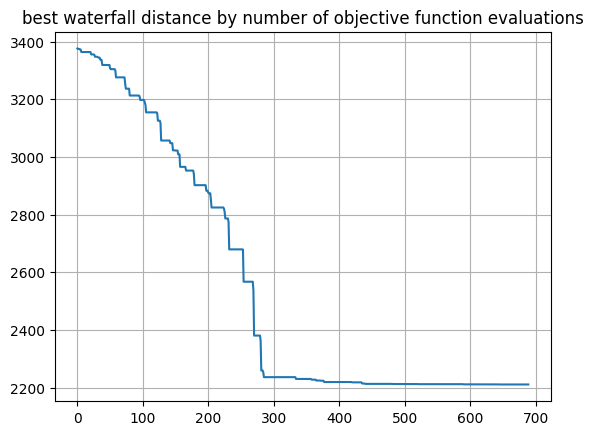

In [14]:
import itertools
import operator

plt.title("best waterfall distance by number of objective function evaluations")
plt.grid()
plt.plot(list(itertools.accumulate((x for _, x in minimize_history), min)))
plt.show()

       message: Maximum number of iterations has been exceeded.
       success: False
        status: 2
           fun: 2210.865180519684
             x: [ 8.839e-02  9.669e-01 ...  6.966e-02  9.610e-01]
           nit: 400
          nfev: 690
 final_simplex: (array([[ 8.839e-02,  9.669e-01, ...,  6.966e-02,
                         9.610e-01],
                       [ 8.839e-02,  9.669e-01, ...,  6.967e-02,
                         9.610e-01],
                       ...,
                       [ 8.839e-02,  9.669e-01, ...,  6.966e-02,
                         9.610e-01],
                       [ 8.839e-02,  9.669e-01, ...,  6.966e-02,
                         9.610e-01]]), array([ 2.211e+03,  2.211e+03, ...,  2.211e+03,  2.211e+03]))
[ 0.08838892  0.96690897  0.00385913  1.99275679 -0.00300517  1.49028574
  0.06260679  0.33060198  0.0519575   0.67788906  0.04063638  0.79254575
  0.01254509  0.41839314  0.03732796  0.8980866   0.04111746  0.66315926
  0.06966321  0.96100207]


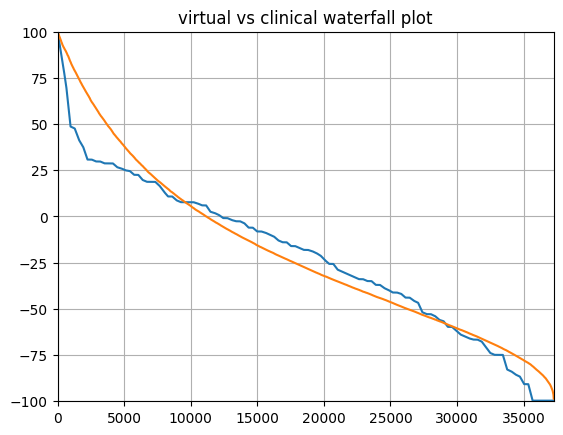

In [16]:
print(result)
print(result.x)

adjust_patient_indicators(indicators, result.x)
virtual_waterfall_plot = waterfall_plot(indicators)
waterfall_plot = waterfall_plot_interpolation(np.arange(virtual_waterfall_plot.shape[0]) / (virtual_waterfall_plot.shape[0] - 1))

plt.title("virtual vs clinical waterfall plot")
plt.grid()
plt.xlim([0, virtual_waterfall_plot.shape[0] - 1])
plt.ylim([-100, 100])

plt.plot(waterfall_plot)
plt.plot(virtual_waterfall_plot)

plt.show()

In [17]:
from scipy.stats import kstest

print(f"ks test: {kstest(population_data, virtual_waterfall_plot, method='exact')}")

ks test: KstestResult(statistic=0.09848937596591431, pvalue=0.19084817575402863, statistic_location=30.80895009, statistic_sign=1)
